In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

import scipy.stats as ss

import warnings
warnings.filterwarnings("ignore")

In [2]:
np.set_printoptions(precision=6)

In [3]:
ALL_VAR = ['AGEP','REGION','DIVISION','ST','ADJINC','COW','DEAR','MAR',
            'DDRS','DOUT','DPHY','DRAT','INTP','SEX','RAC1P','POVPIP','PINCP', 'HINS4']
TARGET = 'HINS4'
PROTECTED_VAR = 'PINCP'
PROTECTED_THRE = 20000
NUMERIC_VAR = ['AGEP', 'INTP', 'POVPIP', 'PINCP']
CATEGORICAL_VAR = ['REGION','DIVISION','ST','ADJINC','COW','DEAR','MAR','DDRS','DOUT','DPHY','DRAT','SEX','RAC1P']

SPLIT_PERCENT = 0.3
SEED = 10

## read data,  filter features, and drop na in numeric variables

In [180]:
def read_data_and_filter_features(path):
    # read data
    all_df = pd.read_csv(path)
    # filter features and drop na in numeric variables
    df = all_df[ALL_VAR].dropna(subset=NUMERIC_VAR)
    print('Original data shape:{}'.format(df.shape))
    return df

In [181]:
data_ori = read_data_and_filter_features('psam_pusa.csv')

Original data shape:(3737574, 18)


In [345]:
data = data_ori.copy()

In [346]:
data.head(10)

,AGEP,REGION,DIVISION,ST,ADJINC,COW,DEAR,MAR,DDRS,DOUT,DPHY,DRAT,INTP,SEX,RAC1P,POVPIP,PINCP,HINS4
1,55,3,6,1,1061971,1.0,2,1,2.0,2.0,2.0,NaN,0.0,2,2,501.0,52000.0,2
2,56,3,6,1,1061971,6.0,2,1,2.0,2.0,2.0,NaN,0.0,1,2,501.0,99000.0,2
3,21,3,6,1,1061971,NaN,2,5,2.0,2.0,2.0,NaN,0.0,1,2,501.0,0.0,2
4,21,3,6,1,1061971,NaN,2,5,1.0,1.0,1.0,NaN,0.0,2,2,501.0,0.0,2
5,63,3,6,1,1061971,3.0,2,3,2.0,2.0,2.0,NaN,0.0,2,2,330.0,39930.0,2
6,61,3,6,1,1061971,NaN,2,4,2.0,1.0,1.0,NaN,0.0,2,3,61.0,10300.0,2
7,20,3,6,1,1061971,1.0,2,5,2.0,2.0,2.0,NaN,0.0,1,3,61.0,1100.0,2
9,78,3,6,1,1061971,2.0,1,2,2.0,2.0,2.0,NaN,0.0,2,2,35.0,3900.0,1
10,81,3,6,1,1061971,NaN,2,2,2.0,2.0,2.0,NaN,0.0,2,1,48.0,5400.0,2
11,59,3,6,1,1061971,1.0,2,1,2.0,2.0,2.0,NaN,0.0,1,1,501.0,90000.0,2


## deal with imbalance

In [347]:
def keep_balance(df):
#     dft = df.copy()
    # keep balance by under-sampling
    df_0 = df[df[TARGET] == 2].sample(n=df[TARGET].value_counts()[1], random_state=1)
    df_1 = df[df[TARGET] == 1]
    balanced_all_df = pd.concat([df_0, df_1])
    # separate X and Y
    balanced_X = balanced_all_df.copy().drop([TARGET], axis=1, inplace=False)
    balanced_Y = balanced_all_df[['HINS4']]
    print('Data shape of balanced_X is {}, data shape of balanced_Y is {}'.format(balanced_X.shape, balanced_Y.shape))
    return balanced_X, balanced_Y

In [348]:
bal_X, bal_Y = keep_balance(data)

Data shape of balanced_X is (1172098, 17), data shape of balanced_Y is (1172098, 1)


In [349]:
bal_X.head()

,AGEP,REGION,DIVISION,ST,ADJINC,COW,DEAR,MAR,DDRS,DOUT,DPHY,DRAT,INTP,SEX,RAC1P,POVPIP,PINCP
1850892,50,4,9,6,1035988,1.0,2,5,2.0,2.0,2.0,NaN,0.0,1,1,235.0,29000.0
2035336,65,4,9,6,1029257,1.0,2,1,2.0,2.0,2.0,NaN,110.0,1,1,501.0,120110.0
3880623,87,3,5,12,1029257,NaN,2,1,2.0,2.0,1.0,NaN,20000.0,1,1,501.0,47800.0
1369575,37,4,9,6,1045195,2.0,2,1,2.0,2.0,2.0,NaN,700.0,2,1,293.0,6850.0
1966362,28,4,9,6,1029257,1.0,2,1,2.0,2.0,2.0,NaN,0.0,2,1,387.0,0.0


In [350]:
bal_Y.head()

,HINS4
1850892,2
2035336,2
3880623,2
1369575,2
1966362,2


In [351]:
bal_Y[TARGET].value_counts()

2    586049
1    586049
Name: HINS4, dtype: int64

## deal with categorical variables

In [352]:
def apply_one_hot(df):
    for v in CATEGORICAL_VAR:
        df = pd.get_dummies(df, columns=[v], prefix = [v], dummy_na=True)
    print('One-hot encoding data shape:{}'.format(df_oh.shape))
    return df

In [353]:
df_oh = apply_one_hot(bal_X)

One-hot encoding data shape:(1172098, 82)


In [354]:
df_oh.head()

,AGEP,INTP,POVPIP,PINCP,REGION_1.0,REGION_3.0,REGION_4.0,REGION_nan,DIVISION_1.0,DIVISION_5.0,...,RAC1P_1.0,RAC1P_2.0,RAC1P_3.0,RAC1P_4.0,RAC1P_5.0,RAC1P_6.0,RAC1P_7.0,RAC1P_8.0,RAC1P_9.0,RAC1P_nan
1850892,50,0.0,235.0,29000.0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2035336,65,110.0,501.0,120110.0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3880623,87,20000.0,501.0,47800.0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
1369575,37,700.0,293.0,6850.0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1966362,28,0.0,387.0,0.0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0


## split train and test

In [355]:
def split_train_test(df_one_hot, balanced_Y):
    X_train, X_test, y_train, y_test = train_test_split(df_one_hot, balanced_Y, \
                                                        test_size=SPLIT_PERCENT, random_state=SEED)
    return X_train, X_test, y_train, y_test

In [356]:
X_tra, X_test, y_tra, y_test = split_train_test(df_oh, bal_Y)

In [357]:
y_tra.head()

,HINS4
1998924,2
1397758,2
387200,2
3710653,2
932564,1


In [358]:
y_test.head()

,HINS4
2887005,1
3609908,1
3474276,1
1864492,1
1090797,2


In [274]:
#########
# X_tra, X_test, y_tra, y_test = split_train_test(data.iloc[ :, :-1], data.iloc[ :, -1:])
# X_tra.head()

In [359]:
y_tra.replace([1.0, 2.0], [1, 0], inplace=True)
y_test.replace([1.0, 2.0], [1, 0], inplace=True)
# y_tra
# y_test

In [360]:
y_tra.head()

,HINS4
1998924,0
1397758,0
387200,0
3710653,0
932564,1


In [361]:
y_test.head()

,HINS4
2887005,1
3609908,1
3474276,1
1864492,1
1090797,0


## standardizing for numeric variables

In [362]:
def cal_mean_var(X_train, X_test):
    train_prot_mean, train_prot_var = ss.describe(X_train[PROTECTED_VAR])[2], ss.describe(X_train[PROTECTED_VAR])[3]
    test_prot_mean, test_prot_var = ss.describe(X_test[PROTECTED_VAR])[2], ss.describe(X_test[PROTECTED_VAR])[3]
    return train_prot_mean, train_prot_var, test_prot_mean, test_prot_var

In [363]:
tra_prot_mean, tra_prot_var, test_prot_mean, test_prot_var = cal_mean_var(X_tra, X_test)

In [364]:
def standardize_numeric_var(X_train, X_test, show = False):
    X_train_std = X_train.copy()
    X_test_std = X_test.copy()
    scaler = StandardScaler().fit(X_train_std[NUMERIC_VAR].values)
    X_train_std[NUMERIC_VAR] = scaler.transform(X_train_std[NUMERIC_VAR].values)
    X_test_std[NUMERIC_VAR] = scaler.transform(X_test_std[NUMERIC_VAR].values) #NUMERIC_VAR
    
#     if show == True:
#         for i in NUMERIC_VAR:
#             col_train = X_train[i]
#             col_stats_train = ss.describe(col_train)
#             print('\n', 'train data, ', i, '===', col_stats_train)
#             col_test = X_test[i]
#             col_stats_test = ss.describe(col_test)
#             print('\n', 'test data, ', i, '===', col_stats_test)
    return X_train_std, X_test_std, scaler 

In [365]:
X_tra_std, X_test_std, sc = standardize_numeric_var(X_tra, X_test)

In [322]:
X_tra_std.head()

,AGEP,INTP,POVPIP,PINCP,REGION_1.0,REGION_3.0,REGION_4.0,REGION_nan,DIVISION_1.0,DIVISION_5.0,...,RAC1P_1.0,RAC1P_2.0,RAC1P_3.0,RAC1P_4.0,RAC1P_5.0,RAC1P_6.0,RAC1P_7.0,RAC1P_8.0,RAC1P_9.0,RAC1P_nan
1998924,-0.052925,-0.111409,1.408679,0.200082,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1397758,0.840603,-0.111409,0.507421,-0.223680,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
387200,-0.400408,-0.111409,1.408679,0.045987,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3710653,-1.542139,-0.111409,1.408679,-0.570393,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
932564,-1.492498,-0.111409,-0.212416,-0.474084,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [323]:
X_tra.head()

,AGEP,INTP,POVPIP,PINCP,REGION_1.0,REGION_3.0,REGION_4.0,REGION_nan,DIVISION_1.0,DIVISION_5.0,...,RAC1P_1.0,RAC1P_2.0,RAC1P_3.0,RAC1P_4.0,RAC1P_5.0,RAC1P_6.0,RAC1P_7.0,RAC1P_8.0,RAC1P_9.0,RAC1P_nan
1998924,46,0.0,501.0,40000.0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1397758,64,0.0,347.0,18000.0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
387200,39,0.0,501.0,32000.0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3710653,16,0.0,501.0,0.0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
932564,17,0.0,224.0,5000.0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [324]:
X_test_std.head()

,AGEP,INTP,POVPIP,PINCP,REGION_1.0,REGION_3.0,REGION_4.0,REGION_nan,DIVISION_1.0,DIVISION_5.0,...,RAC1P_1.0,RAC1P_2.0,RAC1P_3.0,RAC1P_4.0,RAC1P_5.0,RAC1P_6.0,RAC1P_7.0,RAC1P_8.0,RAC1P_9.0,RAC1P_nan
2887005,0.145637,-0.111409,1.408679,-0.549205,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3609908,2.329817,-0.111409,-0.516737,-0.192861,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
3474276,-0.499689,-0.111409,-1.119527,-0.404741,0,1,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
1864492,-0.052925,-0.111409,-0.189006,-0.504903,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1090797,-1.293937,-0.111409,1.408679,-0.416298,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [325]:
X_test.head()

,AGEP,INTP,POVPIP,PINCP,REGION_1.0,REGION_3.0,REGION_4.0,REGION_nan,DIVISION_1.0,DIVISION_5.0,...,RAC1P_1.0,RAC1P_2.0,RAC1P_3.0,RAC1P_4.0,RAC1P_5.0,RAC1P_6.0,RAC1P_7.0,RAC1P_8.0,RAC1P_9.0,RAC1P_nan
2887005,50,0.0,501.0,1100.0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3609908,94,0.0,172.0,19600.0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
3474276,37,0.0,69.0,8600.0,0,1,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
1864492,46,0.0,228.0,3400.0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1090797,21,0.0,501.0,8000.0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0


## separate interest groups

In [326]:
X_tra['PINCP'].max()

1381000.0

In [406]:
X_tra_std['PINCP'].max()

26.030242654685328

In [407]:
def cal_protect_thre(train_prot_mean, train_prot_var, test_prot_mean, test_prot_var):
    # cal thre, standardization : (x - mean) / standard deviation
    train_prot_thre = (PROTECTED_THRE - train_prot_mean) / (train_prot_var**(1/2))
    test_prot_thre = (PROTECTED_THRE - test_prot_mean) / (test_prot_var**(1/2))
    return train_prot_thre, test_prot_thre

In [408]:
tra_prot_thre, test_prot_thre= cal_protect_thre(tra_prot_mean, tra_prot_var, test_prot_mean, test_prot_var)

In [410]:
tra_prot_mean, tra_prot_var, test_prot_mean, test_prot_var

(29612.556744443416, 2695279788.274157, 29544.59633421494, 2663719798.402346)

In [409]:
tra_prot_thre, test_prot_thre

(-0.1851556586189203, -0.18493252369852106)

In [411]:
X_tra_std.head()

,AGEP,INTP,POVPIP,PINCP,REGION_1.0,REGION_3.0,REGION_4.0,REGION_nan,DIVISION_1.0,DIVISION_5.0,...,RAC1P_1.0,RAC1P_2.0,RAC1P_3.0,RAC1P_4.0,RAC1P_5.0,RAC1P_6.0,RAC1P_7.0,RAC1P_8.0,RAC1P_9.0,RAC1P_nan
1998924,-0.052925,-0.111409,1.408679,0.200082,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1397758,0.840603,-0.111409,0.507421,-0.223680,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
387200,-0.400408,-0.111409,1.408679,0.045987,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3710653,-1.542139,-0.111409,1.408679,-0.570393,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
932564,-1.492498,-0.111409,-0.212416,-0.474084,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [422]:
y_tra.head()

,HINS4
1998924,0
1397758,0
387200,0
3710653,0
932564,1


In [437]:
len(pd.concat([X_tra_std, y_tra], axis=1))

820468

In [439]:
def separate_prior_group(X_train_std, X_test_std, Y_train, Y_test, train_prot_thre, test_prot_thre):
    # train data
    df_train = pd.concat([X_train_std, Y_train], axis=1)
    df_train_prot_h_y_1 = df_train.loc[(df_train[PROTECTED_VAR] > train_prot_thre) & (df_train[TARGET] == 1)]
    df_train_prot_l_y_1 = df_train.loc[(df_train[PROTECTED_VAR] <= train_prot_thre) & (df_train[TARGET] == 1)]
    df_train_prot_h_y_0 = df_train.loc[(df_train[PROTECTED_VAR] > train_prot_thre) & (df_train[TARGET] == 0)]
    df_train_prot_l_y_0 = df_train.loc[(df_train[PROTECTED_VAR] <= train_prot_thre) & (df_train[TARGET] == 0)]
    print(df_train_prot_h_y_1.shape, df_train_prot_l_y_1.shape, df_train_prot_h_y_0.shape, df_train_prot_l_y_0.shape)
    # test data
    df_test = pd.concat([X_test_std, Y_test], axis=1)
    df_test_prot_h_y_1 = df_test.loc[(df_test[PROTECTED_VAR] > test_prot_thre) & (df_test[TARGET] == 1)]
    df_test_prot_l_y_1 = df_test.loc[(df_test[PROTECTED_VAR] <= test_prot_thre) & (df_test[TARGET] == 1)]
    df_test_prot_h_y_0 = df_test.loc[(df_test[PROTECTED_VAR] > test_prot_thre) & (df_test[TARGET] == 0)]
    df_test_prot_l_y_0 = df_test.loc[(df_test[PROTECTED_VAR] <= test_prot_thre) & (df_test[TARGET] == 0)]
    print(df_test_prot_h_y_1.shape, df_test_prot_l_y_1.shape, df_test_prot_h_y_0.shape, df_test_prot_l_y_0.shape)
    return df_train_prot_h_y_1, df_train_prot_l_y_1, df_train_prot_h_y_0, df_train_prot_l_y_0, df_test_prot_h_y_1, df_test_prot_l_y_1, df_test_prot_h_y_0, df_test_prot_l_y_0 

In [331]:
# def separate_interest_groups(X_train, X_test):


def separate_interest_groups(X_train_std, X_test_std, train_prot_mean, train_prot_var, test_prot_mean, test_prot_var):
#     cal thre, standardization : (x - mean) / standard deviation
    train_prot_thre = (PROTECTED_THRE - train_prot_mean) / (train_prot_var**(1/2))
    test_prot_thre = (PROTECTED_THRE - test_prot_mean) / (test_prot_var**(1/2))
    # train data
    pr_1_train = X_train_std[X_train_std[PROTECTED_VAR] <= train_prot_thre]
    pr_0_train = X_train_std[X_train_std[PROTECTED_VAR] > train_prot_thre]
    # test data
    pr_1_test = X_test_std[X_test_std[PROTECTED_VAR] <= test_prot_thre]
    pr_0_test = X_test_std[X_test_std[PROTECTED_VAR] > test_prot_thre]
    print(pr_0_train.shape, pr_0_train.shape, pr_1_test.shape, pr_0_test.shape)
    
#     # cal thre, standardization : (x - mean) / standard deviation
#     # train data
#     pr_1_train = X_train[X_train[PROTECTED_VAR] <= PROTECTED_THRE]
#     pr_0_train = X_train[X_train[PROTECTED_VAR] > PROTECTED_THRE]
#     # test data
#     pr_1_test = X_test[X_test[PROTECTED_VAR] <= PROTECTED_THRE]
#     pr_0_test = X_test[X_test[PROTECTED_VAR] > PROTECTED_THRE]
#     print(pr_0_train.shape, pr_0_train.shape, pr_1_test.shape, pr_0_test.shape)
    
    return pr_1_train, pr_0_train, pr_1_test, pr_0_test

In [332]:
tra_prot_mean, tra_prot_var, test_prot_mean, test_prot_var

(29612.556744443416, 2695279788.274157, 29544.59633421494, 2663719798.402346)

In [343]:
p_1_tra_std, p_0_tra_std, p_1_test_std, p_0_test_std = separate_interest_groups(X_tra_std, X_test_std, tra_prot_mean, tra_prot_var, test_prot_mean, test_prot_var)

(321885, 82) (321885, 82) (213543, 82) (138087, 82)


In [333]:
y_tra.head()

,HINS4
1998924,0
1397758,0
387200,0
3710653,0
932564,1


### Compute ratio 

<p>
ratio_1 = #(p_1 & y_train ==1)/#(y_train==1) 
 </p>
 
 <p>

ratio_2 = #(p_0 & y_train ==1)/#(y_train==1)
</p>

<p>
    where p_1, p_0 are two interests groups: p_1 = income less than 20k, p_0 = income greater than 20k,
    y_train = 1 
    (HINS4 (coverage through Medicaid, Medical Assistance, or any kind of government-assistance plan for those with low incomes or a disability))
</p>

In [334]:
# Fairness matrix
def get_ratio(p_set, y, yvalue):
    numerator = len(np.where(y.loc[p_set.index].values==yvalue)[0])
    total = len(np.where(y.values==yvalue)[0])
    return numerator / total

def cal_train_fairness(p_1_train, p_0_train, y_train):
    # ratio 1 and ratio 2
    r_0 = get_ratio(p_1_train, y_train, 1)
    r_1 = get_ratio(p_0_train, y_train, 1)
    ratio = r_0 / r_1
    print('fairness_ratio = {} / {} = {}'.format(r_0, r_1, ratio))
    return r_0, r_1, ratio

In [335]:
tra_pri_0, tra_pri_1, tra_fairness = cal_train_fairness(p_1_tra, p_0_tra, y_tra)

fairness_ratio = 0.8104233622207375 / 0.1895766377792625 = 4.274911569875877


In [366]:
tra_pri_0_std, tra_pri_1_std, tra_fairness_std = cal_train_fairness(p_1_tra_std, p_0_tra_std, y_tra)

fairness_ratio = 0.8104233622207375 / 0.1895766377792625 = 4.274911569875877


## Training Logistic Regression Model 

In [444]:
def compute_t(fairness):
    return (1/fairness) - 1

def compute_fairness(t):
    return (1/(1+t))

In [449]:
def train_LR_without_reg(X_train, y_train, X_test, y_test, p_1_test_std, p_0_test_std, scaler):
    res_list = []
    for f in fairness:
        res = {}
        t = compute_t(f)
        res["fairness"], res["t"] = f, t

        clf = LogisticRegression()

        ## Train
        clf.fit(X_train,y_train)
        res['coef'], res['train acc'] = clf.coef_, clf.score(X_train, y_train)

        ## Test
        y_pred = clf.predict(X_test)
        cfm = confusion_matrix(y_test.values, y_pred)
        res['test acc'], res['confusion matrix'] = accuracy_score(y_test.values, y_pred), cfm

        ## Fairness, p_1_test, p_0_test
        y_pred_p1 = clf.predict(p_1_test_std)
        y_pred_p0 = clf.predict(p_0_test_std)
        ratio_1 = len(np.where(y_pred_p1 == 1)[0])
        ratio_2 = len(np.where(y_pred_p0 == 1)[0])
        res['test fairness'] = ratio_1 / ratio_2
        test_precision = metrics.precision_score(y_test, y_pred)
        test_recall = metrics.recall_score(y_test, y_pred)
        res['test Precision'], res['test Recall'] = test_precision, test_recall

        print('f = ', f)
        print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
        print("Precision:", test_precision)
        print("Recall:", test_recall)
        print(f"Test fairness: {ratio_1/ratio_2}")

        res_list.append(res)
    return res_list

In [452]:
LR_res_wo_reg = train_LR_without_reg(X_tra_std, y_tra, X_test_std, y_test, p_1_test_std, p_0_test_std, sc)

f =  0.7
Accuracy: 0.7567243978045104
Precision: 0.745103780337042
Recall: 0.7810015288347324
Test fairness: 6.877835205672547


In [454]:
## Consider Fairness - 0.8 - initial value
fairness = [0.7]
lambdas = [10**3,10**3], [10**6, 10**6], [10**9, 10**9], [10**12, 10**12], [10**15, 10**15]
# [[10**i, 10**i] for i in range(4, 16)]
# 

def train_LR_with_reg(prior_0, prior_1, X_train, y_train, X_test, y_test, p_1_test_std, p_0_test_std, scaler):
    res_list = []
    for f in fairness:
        res = {}
        t = compute_t(f)

        prior1 = (prior_0 - (1/(1+t)))
        prior2 = (prior_1 - (t/(1+t)))

        for (l1,l2) in lambdas:
            res = {}
            res["fairness"], res["t"], res['l1'], res['l2'] = f, t, l1, l2
            
            c = (l1*prior1 + l2*prior2)
            clf = LogisticRegression(C=c)
            
            ## Train
            clf.fit(X_train,y_train)
            res['coef'], res['train acc'] = clf.coef_, clf.score(X_train, y_train)

            ## Test
            y_pred = clf.predict(X_test)
            cfm = confusion_matrix(y_test.values, y_pred)
            res['test acc'], res['confusion matrix'] = accuracy_score(y_test.values, y_pred), cfm
            
            ## Fairness, p_1_test, p_0_test
            y_pred_p1 = clf.predict(p_1_test_std)
            y_pred_p0 = clf.predict(p_0_test_std)
            ratio_1 = len(np.where(y_pred_p1 == 1)[0])
            ratio_2 = len(np.where(y_pred_p0 == 1)[0])
            res['test fairness'] = ratio_1 / ratio_2
            test_precision = metrics.precision_score(y_test, y_pred)
            test_recall = metrics.recall_score(y_test, y_pred)
            res['test Precision'], res['test Recall'] = test_precision, test_recall
            
            print('f = ', f, ', l1 = ', l1, ', l2 = ', l2)
            print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
            print("Precision:", test_precision)
            print("Recall:", test_recall)
            print(f"Test fairness: {ratio_1/ratio_2}")

            res_list.append(res)
    return res_list

In [455]:
LR_res_with_reg = train_LR_with_reg(tra_pri_0, tra_pri_1, \
                                   X_tra_std, y_tra, X_test_std, y_test, p_1_test_std, p_0_test_std, sc)

f =  0.7 , l1 =  1000 , l2 =  1000
Accuracy: 0.7474646645621819
Precision: 0.747054688120103
Recall: 0.7488846326534092
Test fairness: 9.034818228366616
f =  0.7 , l1 =  1000000 , l2 =  1000000
Accuracy: 0.7474646645621819
Precision: 0.747054688120103
Recall: 0.7488846326534092
Test fairness: 9.034818228366616
f =  0.7 , l1 =  1000000000 , l2 =  1000000000
Accuracy: 0.7476011716861474
Precision: 0.7442878113829156
Recall: 0.7549772379810288
Test fairness: 8.694095920916844
f =  0.7 , l1 =  1000000000000 , l2 =  1000000000000
Accuracy: 0.754642664164036
Precision: 0.7412486952404523
Recall: 0.7829850356065041
Test fairness: 7.049982674982675
f =  0.7 , l1 =  1000000000000000 , l2 =  1000000000000000
Accuracy: 0.7567386172965902
Precision: 0.7451133486236045
Recall: 0.7810242624367011
Test fairness: 6.879982909634694


6.877835205672547

In [462]:
def visualize_model_selection(result_without_reg, result_with_reg):
    l = [v for i in LR_res for k, v in i.items() if k == 'l1']
    train_acc = [v for i in LR_res for k, v in i.items() if k == 'train acc']
    test_acc = [v for i in LR_res for k, v in i.items() if k == 'test acc']
    test_precision = [v for i in LR_res for k, v in i.items() if k == 'test Precision']
    test_recall = [v for i in LR_res for k, v in i.items() if k == 'test Recall']
    test_fairness = [v for i in LR_res for k, v in i.items() if k == 'test fairness']

    plt.figure()
    plt.plot(l, train_acc, label='train_acc', color='grey')
    plt.plot(l, test_acc, label='test_acc', color='b')
    plt.plot(l, test_precision, label='test_precision', color='g')
    plt.plot(l, test_recall, label='test_recall', color='y')
    plt.title('train and test acc')
    plt.xlabel('lambda')
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.plot(l, test_fairness, label='test_fairness', color='r')
    plt.axhline(y=result_without_reg[0]['test fairness'], color='gray', linestyle='dotted')
    plt.title('test fairness')
    plt.xlabel('lambda')
    plt.show()

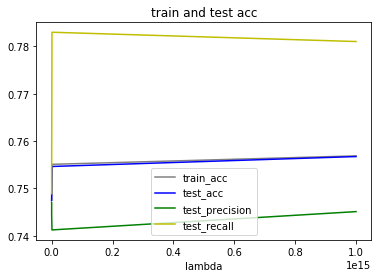

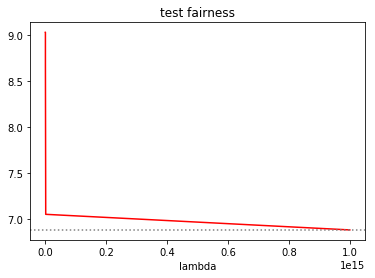

In [463]:
visualize_model_selection(LR_res_wo_reg, LR_res_with_reg)

In [404]:
def visualize_confusion_matrix(cfm):
    sns.heatmap(cfm, annot=True, cmap="YlGnBu" ,fmt='g')
    plt.xlabel('Predicted classes')
    plt.ylabel('Actual classes')
    plt.show()

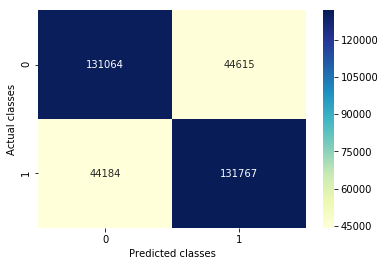

In [405]:
visualize_confusion_matrix(LR_res[1]['confusion matrix'])